# PINN for Simulated Damped Harmonic Oscillator Data

In [56]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Damped Harmonic Oscillator

The initial value problem damped harmonic oscillator equation is given by:

\begin{align}
    \frac{d^2x}{dt^2} + \alpha\frac{dx}{dt} + \beta x = 0, \qquad &x(t=0) = 1 \\
    &\frac{dx}{dt}|_{t=0} = 1
\end{align}

The exact solution to this intial value problem is given by:

$$Ae^{-\gamma t}\cos(\omega t + \phi)$$

In [57]:
def damped_harmonic_oscillator(t, alpha, beta, x0=1.0, v0=1.0) -> np.ndarray:
  gamma = alpha / 2
  assert(beta - gamma**2 > 0) # weak damping condition

  omega = np.sqrt(beta - gamma**2)
  phi = np.arctan(-(v0 + gamma * x0) / (x0 * omega))
  A = x0 / np.cos(phi)

  return A * np.exp(-gamma * t) * np.cos(omega * t + phi)

The training data is obtained by sampling 10

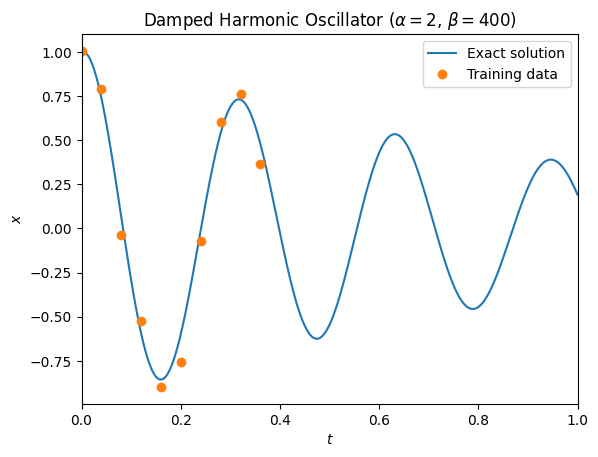

In [95]:
# damping and frequeny parameters
alpha, beta = 2, 400

# calculate exact solution on the
t_data = np.linspace(0, 1, 500)
x_data = damped_harmonic_oscillator(t_data, alpha, beta)

# sample training data
np.random.seed(4)
t_train = t_data[0:200:20]
x_train = x_data[0:200:20] + np.random.normal(scale=np.sqrt(0.01), size=10) # add gaussian white noise

# plot the exact solution and training data
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title(f"Damped Harmonic Oscillator ($\u03b1 = {alpha}$, $\u03b2 = {beta}$)")
ax.plot(t_data, x_data, label="Exact solution")
ax.plot(t_train, x_train, "o", label="Training data")
ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
ax.set_xlim(0, 1)
ax.legend()

In [65]:
fig.savefig('dho_data.png')

# Standard Neural Network

Before constructing a PINN, it is worth considering what happens when we train the neural network without informing any physics. As a demonstration we will train a two neural networks on the data, one for 500 epochs and the other for 1000 epochs.

In [96]:
# returns a standard densely connected neural network
# layers: a list of integers denoting the number of neurons in each layer of the hidden layer
def build_NN(layers):
    NN = tf.keras.Sequential()

    NN.add(tf.keras.layers.Input(shape=(1, ))) # one input variable (t)

    # densely connected hidden layer with tanh activation functions
    for neurons in layers:
        NN.add(tf.keras.layers.Dense(neurons, activation="tanh"))

    NN.add(tf.keras.layers.Dense(1)) # one output variable (x)

    NN.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), # use adam optimizer
        loss=tf.keras.losses.MSE # use mean squared error as loss
    )

    return NN

In [97]:
tf.random.set_seed(0)

# 3 densely connected layers with 40 neurons in each layer
layers = 3 * [40]
NN_500 = build_NN(layers)
NN_1000 = build_NN(layers)

# format the training data so it can be inputed into the neural nets
n_train = t_train.shape[0]
t_train = tf.constant(t_train, shape=(n_train, 1), dtype=tf.float32)
x_train = tf.constant(x_train, shape=(n_train, 1), dtype=tf.float32)

# train the neural nets
NN_500.fit(t_train, x_train, epochs=500)
NN_1000.fit(t_train, x_train, epochs=1000)

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 0.4419
Epoch 2/500
1/1 [==============================] - 0s 14ms/step - loss: 0.4357
Epoch 3/500
1/1 [==============================] - 0s 12ms/step - loss: 0.4308
Epoch 4/500
1/1 [==============================] - 0s 14ms/step - loss: 0.4271
Epoch 5/500
1/1 [==============================] - 0s 14ms/step - loss: 0.4247
Epoch 6/500
1/1 [==============================] - 0s 12ms/step - loss: 0.4234
Epoch 7/500
1/1 [==============================] - 0s 14ms/step - loss: 0.4231
Epoch 8/500
1/1 [==============================] - 0s 13ms/step - loss: 0.4234
Epoch 9/500
1/1 [==============================] - 0s 13ms/step - loss: 0.4241
Epoch 10/500
1/1 [==============================] - 0s 12ms/step - loss: 0.4247
Epoch 11/500
1/1 [==============================] - 0s 11ms/step - loss: 0.4251
Epoch 12/500
1/1 [==============================] - 0s 14ms/step - loss: 0.4252
Epoch 13/500
1/1 [==============================] -

16/16 [==============================] - 0s 2ms/step


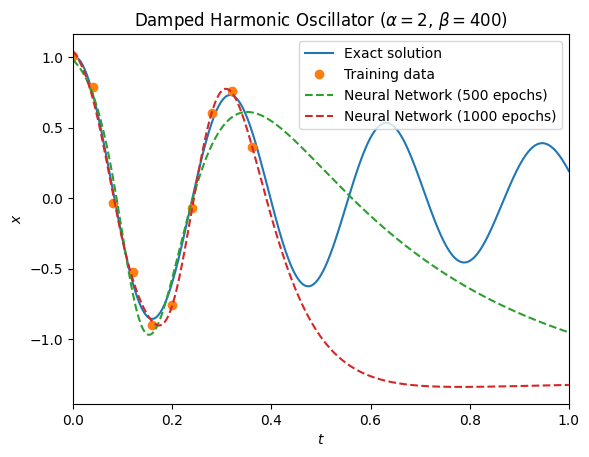

In [98]:
# calculate predictions
x_pred_500 = NN_500.predict(t_data)
x_pred_1000 = NN_1000.predict(t_data)

# plot the results against the eaxt solution and training data
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title(f"Damped Harmonic Oscillator ($\u03b1 = {alpha}$, $\u03b2 = {beta}$)")
ax.plot(t_data, x_data, label="Exact solution")
ax.plot(t_train, x_train, "o", label="Training data")
ax.plot(t_data, x_pred_500, "--", label="Neural Network (500 epochs)")
ax.plot(t_data, x_pred_1000, "--", label="Neural Network (1000 epochs)")
ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
ax.set_xlim(0, 1)
ax.legend()

In [99]:
fig.savefig('regular_neural_network.png')

## Relative Error

We can evaluate the relative error in the prediections as follows:

$$\epsilon = \frac{\sqrt{\sum^N_{i=0}|x^i_{pred} - x^i_{true}|^2}}{\sqrt{\sum^N_{i=0}|x^i_{true}|^2}}$$

In [100]:
def relative_error(x_pred, x_true):
    return tf.math.sqrt(tf.reduce_sum(tf.square(x_pred - x_true))) / tf.math.sqrt(tf.reduce_sum(tf.square(x_true)))

Calculate the error of the two neural networks compare to the exact solution for 500 points across the interval from (0, 1)

In [101]:
print("Relative Error:")
print(f"{relative_error(x_pred_500, x_data)}")
print(f"{relative_error(x_pred_1000, x_data)}")

Relative Error:
35.638040594907864
53.68380395120739


The neural networks have a very high relative error when compared to the exact solution on the interval (0, 1). The above plot shows that the networks tend to overfit to the training data and do not generalise well where there is no training data.

# PINN Setup

For the PINN we use the exact same densely connected neural network. The only difference between the networks is the loss function:

\begin{align}
    &\mathcal{L}_{dho} = \mathcal{L}_{data} + \mathcal{L}_{physics} + \mathcal{L}_{ic} \\
    & \mathcal{L}_{data} = \frac{1}{N_d}\sum_{i=0}^{N_d}||\hat{x}(t^i) - x^i||^2 \nonumber \\
    & \mathcal{L}_{physics} = \frac{1}{N_c}\sum_{i=0}^{N_c}||r_{dho}(t^i_c)||^2 \nonumber \\
    & \mathcal{L}_{ic} = ||r_{ip}||^2 + ||r_{iv}||^2 \nonumber
\end{align}

Additionaly, we include a set of collocation points on which we evaluate the physics term in the loss. These points a spread across the domain on which we want to approximate the the exact solution.

In [110]:
# Physics Informed Neural Network for Damped Harmonic Oscillator

class PINN_damped_harmonic_oscillator():

    # t, x: training data
    # t_collocation: points on which the physics loss is calculated
    # layers: a list of integers denoting the number of neurons in each layer of the hidden layer
    def __init__(self, t, x, t_collocation, layers):

        # parameters
        self.alpha = alpha
        self.beta = beta

        # training data
        self.t = t
        self.x = x

        # collocation points
        self.t_collo = t_collocation

        # for calculating initial condition loss
        self.t0 = tf.constant(0., shape=(1,1))
        self.one = tf.constant(1., shape=(1,1))

        # neural network
        self.neural_net = self.initialize_neural_net(layers)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # adam optimizer
        self.history = [] # record of loss for every epoch


    def initialize_neural_net(self, layers):
        neural_net = tf.keras.Sequential()

        # input layer
        neural_net.add(tf.keras.layers.Input(shape=(1, ))) # one input variable (t)

        # densely connected hidden layer with tanh activations
        for neurons in layers:
            neural_net.add(tf.keras.layers.Dense(neurons, activation='tanh'))

        # output layer
        neural_net.add(tf.keras.layers.Dense(1)) #

        return neural_net


    def predict(self, t):

        return self.neural_net(t)


    def train(self, epochs):

        for epoch in range(1, epochs - 1):

            # evaluate loss
            with tf.GradientTape() as tape:
                loss = self.loss()

            gradients = tape.gradient(loss, self.neural_net.trainable_variables) # calculate the gradients of the loss function with respect to every weight and bias in the network
            self.optimizer.apply_gradients(zip(gradients, self.neural_net.trainable_variables)) # use the Adam optimizer to update every weight and bias using their respective gradient

            # record the loss
            self.history.append(loss.numpy())
            print(f"epoch: {epoch} loss: {loss}")


    def loss(self):

        return self.data_loss() + (1e-3) * self.physics_loss() + self.initial_condition_loss()


    def data_loss(self):

        # mean squared error
        x_pred = self.neural_net(self.t)
        loss = tf.reduce_mean(tf.square(x_pred - self.x))
        return loss


    def physics_loss(self):

        # automatic differentiation
        with tf.GradientTape() as tape1:
            tape1.watch(self.t_collo)

            with tf.GradientTape() as tape2:
                tape2.watch(self.t_collo)
                x = self.neural_net(self.t_collo)

            # first order derivative
            x_t = tape2.gradient(x, self.t_collo)

        # second order derivative
        x_tt = tape1.gradient(x_t, self.t_collo)

        # damped harmonic oscillator equation
        f = x_tt + self.alpha * x_t + self.beta * x
        loss = tf.reduce_mean(tf.square(f))

        return loss


    def initial_condition_loss(self):

        # calculate derivatives
        with tf.GradientTape() as tape:
            tape.watch(self.t0)
            x0 = self.neural_net(self.t0) # initial postion

        v0 = tape.gradient(x0, self.t0) # initial velocity

        loss = tf.reduce_sum(tf.square(x0 - self.one) + tf.square(v0 - self.one))
        return loss



In [111]:
tf.random.set_seed(0)

# 30 evenly spaced collocation points on the interval (0, 1)
t_collocation = np.linspace(0, 1, 30).reshape(-1, 1)
t_collocation = tf.constant(t_collocation, dtype=tf.float32)

# 3 densely connected layers with 40 neurons each
layers = 3 * [40]
PINN = PINN_damped_harmonic_oscillator(t_train, x_train, t_collocation, layers)
PINN.neural_net.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 40)                80        
                                                                 
 dense_73 (Dense)            (None, 40)                1640      
                                                                 
 dense_74 (Dense)            (None, 40)                1640      
                                                                 
 dense_75 (Dense)            (None, 1)                 41        
                                                                 
Total params: 3401 (13.29 KB)
Trainable params: 3401 (13.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [112]:
PINN.train(20_000)

Streaming output truncated to the last 5000 lines.
epoch: 14999 loss: 0.024986138567328453
epoch: 15000 loss: 0.023987719789147377
epoch: 15001 loss: 0.017054665833711624
epoch: 15002 loss: 0.011297427117824554
epoch: 15003 loss: 0.011463903822004795
epoch: 15004 loss: 0.015721049159765244
epoch: 15005 loss: 0.018702618777751923
epoch: 15006 loss: 0.01736781932413578
epoch: 15007 loss: 0.013378530740737915
epoch: 15008 loss: 0.010700548067688942
epoch: 15009 loss: 0.011301785707473755
epoch: 15010 loss: 0.013696684502065182
epoch: 15011 loss: 0.015037932433187962
epoch: 15012 loss: 0.014029484242200851
epoch: 15013 loss: 0.011855287477374077
epoch: 15014 loss: 0.010555720888078213
epoch: 15015 loss: 0.010995435528457165
epoch: 15016 loss: 0.012291905470192432
epoch: 15017 loss: 0.012967743910849094
epoch: 15018 loss: 0.012415861710906029
epoch: 15019 loss: 0.011249518021941185
epoch: 15020 loss: 0.01052350364625454
epoch: 15021 loss: 0.010701684281229973
epoch: 15022 loss: 0.0113762672

(0.0, 20000.0)

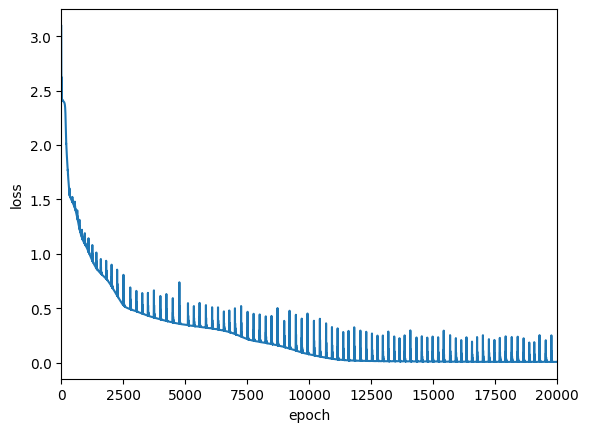

In [169]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(PINN.history)
ax.set_ylabel("loss")
ax.set_xlabel("epoch")
ax.set_xlim(0, 20000)

In [171]:
fig.savefig("simulated_dho_loss.png")

Relative error: 0.014669086784124374


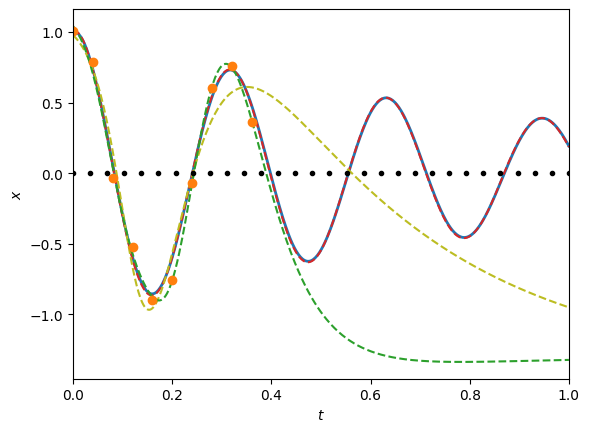

In [166]:
x_pred = PINN.predict(t_data)
print(f"Relative error: {relative_error(x_pred, x_test)}")

fig = plt.figure()
ax = fig.add_subplot(111)

#ax.set_title(f"Damped Harmonic Oscillator ($\u03b1 = {alpha}$, $\u03b2 = {beta}$)")
ax.plot(t_data, x_data, color="tab:blue", label="Exact solution", lw=2)
ax.plot(t_data, x_pred, color="tab:red", linestyle="--", label="PINN (20,000 epochs)")
ax.plot(t_data, x_pred_500, color="tab:olive", linestyle="--", label="NN (500 epochs)")
ax.plot(t_data, x_pred_1000, color="tab:green", linestyle="--", label="NN (500 epochs)")
ax.plot(t_train, x_train, color="tab:orange", marker="o", linestyle="", label="Training data")
ax.plot(t_collocation, np.zeros(30), color="k", marker=".", linestyle="", label="Collocation points")
ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
ax.set_xlim(0, 1)
#ax.legend()
plt.show()


In [167]:
fig.savefig("simulated_dho_prediction.png")

In [129]:
# intial postion
t0 = tf.constant(0.0, shape=(1, 1), dtype=tf.float32)
PINN.predict(t0).numpy()

array([[1.0069679]], dtype=float32)

In [131]:
t0 = tf.constant(0.0, shape=(1, 1), dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(t0)
    x0 = PINN.predict(t0) # initial position

v0 = tape.gradient(x0, t0) # initial velocity

one = tf.constant(1.0, shape=(1, 1), dtype=tf.float32)
print("Percentage error:")
print(f"initial position: {relative_error(x0, one).numpy()}")
print(f"initial velocity: {relative_error(v0, one).numpy()}")

Percentage error:
initial position: 0.006967902183532715
initial velocity: 0.020696938037872314


In [ ]:
PINN.neural_net.save('dho_20000_4p_0896')
np.save('dho_20000_4p_0896.npy', np.array(PINN.history))
fig.savefig('dho_20000_4p_0896.png')

In [116]:
class NN_discovery(tf.keras.Sequential):

    def __init__(self):
        super().__init__()
        self.alpha = tf.Variable(initial_value=1.0, trainable=True)
        self.beta = tf.Variable(initial_value=1.0, trainable=True)


In [137]:
class PINN_damped_harmonic_oscillator_discovery():

    def __init__(self, t, x, t_collocation, layers):

        # training data
        self.t = t
        self.x = x

        # collocation points
        self.t_collo = t_collocation

        # for calculating initial condition loss
        self.t0 = tf.constant(0., shape=(1,1))
        self.one = tf.constant(1., shape=(1,1))

        # neural network
        self.neural_net = self.initialize_neural_net(layers)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.history = []


    def initialize_neural_net(self, layers):
        neural_net = NN_discovery()

        # input layer
        neural_net.add(tf.keras.layers.Input(shape=(1, )))

        # hidden layers
        for neurons in layers:
            neural_net.add(tf.keras.layers.Dense(neurons, activation='tanh'))

        # output layer
        neural_net.add(tf.keras.layers.Dense(1))

        return neural_net


    def predict(self, t):

        return self.neural_net(t)


    def train(self, epochs):

        for epoch in range(1, epochs - 1):
            with tf.GradientTape() as tape:
                loss = self.loss()

            gradients = tape.gradient(loss, self.neural_net.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.neural_net.trainable_variables))

            self.history.append(loss.numpy())
            print(f"epoch: {epoch} loss: {loss}")


    def loss(self):

        return self.data_loss() + (1e-4) * self.physics_loss() #+ self.initial_condition_loss()


    def data_loss(self):

        x_pred = self.neural_net(self.t)
        loss = tf.reduce_mean(tf.square(x_pred - self.x))
        return loss


    def physics_loss(self):

        with tf.GradientTape() as tape1:
            tape1.watch(self.t_collo)

            with tf.GradientTape() as tape2:
                tape2.watch(self.t_collo)
                x = self.neural_net(self.t_collo)

            # first order derivative
            x_t = tape2.gradient(x, self.t_collo)

        # second order derivative
        x_tt = tape1.gradient(x_t, self.t_collo)

        # damped harmonic oscillator equation
        f = x_tt + self.neural_net.alpha * x_t + self.neural_net.beta * x
        loss = tf.reduce_mean(tf.square(f))

        return loss


    def initial_condition_loss(self):

        with tf.GradientTape() as tape:
            tape.watch(self.t0)
            x0 = self.neural_net(self.t0)

        v0 = tape.gradient(x0, self.t0)

        loss = tf.reduce_sum(tf.square(x0 - self.one) + tf.square(v0 - self.one))
        return loss



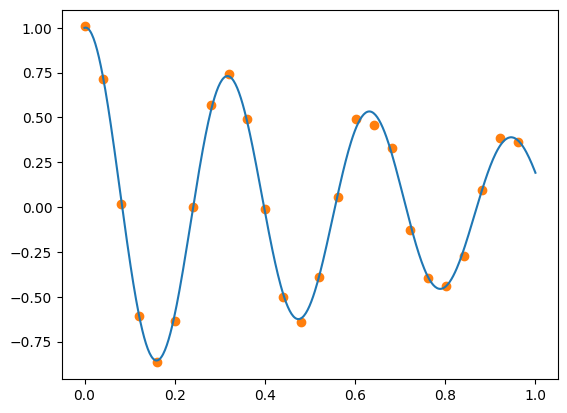

In [172]:
np.random.seed(34)
t_discovery = t_data[0::20]
x_discovery = x_data[0::20] + np.random.normal(scale=np.sqrt(0.001), size=25)

plt.plot(t_data, x_data)
plt.scatter(t_discovery, x_discovery, color="tab:orange")

In [173]:
layers = 8 * [40]
PINN_discovery = PINN_damped_harmonic_oscillator_discovery(t_discovery, x_discovery, t_collocation, layers)
PINN_discovery.neural_net.summary()

Model: "nn_discovery_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 40)                80        
                                                                 
 dense_113 (Dense)           (None, 40)                1640      
                                                                 
 dense_114 (Dense)           (None, 40)                1640      
                                                                 
 dense_115 (Dense)           (None, 40)                1640      
                                                                 
 dense_116 (Dense)           (None, 40)                1640      
                                                                 
 dense_117 (Dense)           (None, 40)                1640      
                                                                 
 dense_118 (Dense)           (None, 40)             

In [174]:
PINN_discovery.neural_net.trainable_variables[-1]

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>

In [175]:
PINN_discovery.train(10_000)

epoch: 1 loss: 0.32455456256866455
epoch: 2 loss: 0.2560431957244873
epoch: 3 loss: 0.2575646936893463
epoch: 4 loss: 0.2732289731502533
epoch: 5 loss: 0.2720968723297119
epoch: 6 loss: 0.2624157965183258
epoch: 7 loss: 0.2540218234062195
epoch: 8 loss: 0.25063395500183105
epoch: 9 loss: 0.2516635060310364
epoch: 10 loss: 0.2545611560344696
epoch: 11 loss: 0.2567512094974518
epoch: 12 loss: 0.2570767402648926
epoch: 13 loss: 0.2558094263076782
epoch: 14 loss: 0.2538447976112366
epoch: 15 loss: 0.2520345151424408
epoch: 16 loss: 0.25089162588119507
epoch: 17 loss: 0.25055721402168274
epoch: 18 loss: 0.2508781850337982
epoch: 19 loss: 0.2515195608139038
epoch: 20 loss: 0.25210559368133545
epoch: 21 loss: 0.25236988067626953
epoch: 22 loss: 0.25224241614341736
epoch: 23 loss: 0.2518274188041687
epoch: 24 loss: 0.251311719417572
epoch: 25 loss: 0.2508696913719177
epoch: 26 loss: 0.25060728192329407
epoch: 27 loss: 0.2505488097667694
epoch: 28 loss: 0.25065210461616516
epoch: 29 loss: 0.250

KeyboardInterrupt: 

alpha = 0.9874433875083923
beta = 0.9670069217681885
Relative error: 0.9987325072288513


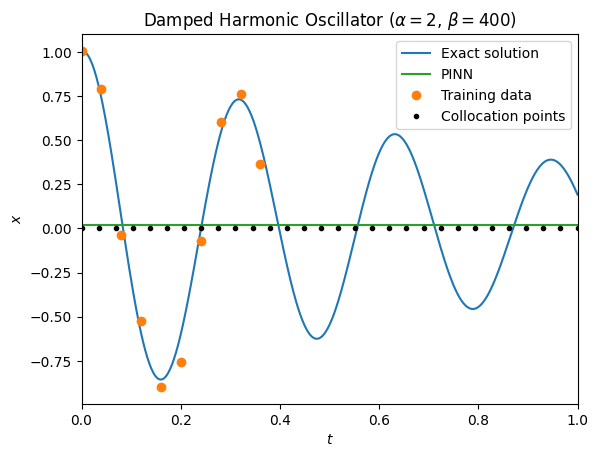

In [155]:
x_pred = PINN_discovery.predict(t_data)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title(f"Damped Harmonic Oscillator ($\u03b1 = {alpha}$, $\u03b2 = {beta}$)")
ax.plot(t_data, x_data, color="tab:blue", label="Exact solution")
ax.plot(t_data, x_pred, color="tab:green", label="PINN")
ax.plot(t_train, x_train, color="tab:orange", marker="o", linestyle="", label="Training data")
ax.plot(t_collocation, np.zeros(30), color="k", marker=".", linestyle="", label="Collocation points")
ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
ax.set_xlim(0, 1)
ax.legend()

print(f"alpha = {PINN_discovery.neural_net.alpha.numpy()}")
print(f"beta = {PINN_discovery.neural_net.beta.numpy()}")
print(f"Relative error: {relative_error(x_pred, x_test)}")

In [ ]:
PINN.neural_net.save('dho_discovery_10000')
np.save('dho_discovery_10000.npy', np.array(PINN.history))
fig.savefig('dho_discovery_10000.png')